In [1]:
import sys
import pandas as pd
import json

/var/folders/_3/wtwzgv1d3rlfz233qkf36kg00000gp/T/ipykernel_26116/1780099861.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [70]:
df_neg = pd.read_csv('data/codex/test_negatives.txt', sep='\t', header=None, names=['Head','Relation','Tail'])

In [73]:
def_pos = pd.read_csv('data/codex/test.txt', sep='\t', header=None, names=['Head','Relation','Tail'])

In [2]:
df = pd.read_csv('data/codex/train.txt', sep='\t', header=None, names=['Head','Relation','Tail'])

In [9]:
with open('data/codex/entities.json', 'r') as file:
    entities = json.load(file)

with open('data/codex/relations.json', 'r') as file:
    relations = json.load(file)

In [20]:
name_dict = {}
for id, row in df.iterrows():
    # get id
    head_id = row['Head']
    relation_id = row['Relation']
    tail_id = row['Tail']
    # get label out of id
    head = entities[head_id]['label']
    relation = relations[relation_id]['label']
    tail = entities[tail_id]['label']
    name_dict[id] = [head,relation,tail]


In [21]:
name_df = pd.DataFrame.from_dict(name_dict,orient='index',columns=['Head','Relation','Tail'])

In [23]:
import ollama

In [31]:
# Function to interract with llm

def row2text(row):
    # Translate triple into text
    head = row['Head']
    relation = row['Relation']
    tail = row['Tail']
    prompt = f"Transform the following triple :({head},{relation},{tail}) into natural language text. Don't explain your choice"
    response = ollama.generate(model='mistral', 
            prompt= prompt)
    triple_text = response['response']
    return triple_text, head, relation, tail

def extract_score(text):
    # Function to extract score
    # Find the starting index of "Score: "
    start_index = text.find("Score: ") + len("Score: ")

    # Find the end of the number, which could be marked by a non-digit character
    end_index = start_index
    while end_index < len(text) and (text[end_index].isdigit() or text[end_index] == '.'):
        end_index += 1

    # Extract and return the number using slicing
    return text[start_index:end_index]

In [54]:
# eval without context
def eval_text(triple_text):
    # give a score for a text
    prompt = f'We have the below sentence and you need to validate that and give a score to that.'
    prompt += f'given that a 0 is a score corresponding to invalide triple and 1 to valide triple give the corresponding score to this triple.'
    prompt += f"Is the following sentence :'{triple_text}' valid."
    prompt += f"Start your answer with :'Score:', if you can not determine if it is accurate give it a score of 0.5"
    response = ollama.generate(model='mistral', 
            prompt= prompt)
    text = response['response']
    print('Eval text:\n')
    print(text)
    score = extract_score(text)
    return score

def eval_df(df, size):
    # evaluate subsample of df with llm
    score_list = []
    idx = 0
    for index, row in df[:size].iterrows():
        triple_text, head, relation, tail = row2text(row)
        print('Triple text:\n')
        print(triple_text)
        score = eval_text(triple_text)
        score_list.append(score)
        idx+= 1
        if idx%100 == 0:
            print(f'{idx}/{size}')
    print('Finished\n')
    return score_list


In [66]:
# Function to get context

def get_context_triple(df:pd.DataFrame, col_name:str, elem_comp:str, max_sample:int) -> list[str]:
    # get context triple
    context_df = df[df[col_name] == elem_comp]
    if len(context_df) > max_sample:
        context_df = context_df.sample(max_sample)
    list_triple = []
    for _,context_row in context_df.iterrows():
        head = context_row['Head']
        relation = context_row['Relation']
        tail = context_row['Tail']
        list_triple.append(f'({head},{relation},{tail})')
    return list_triple

def eval_text_context(triple_text, context_head, context_rel, context_tail):
    # give a score for a text with context
    prompt = f'We have the below sentence and you need to validate that and give a score to that.'
    prompt += f'given that a 0 is a score corresponding to invalid sentence and 1 to valid sentence give the corresponding score to this triple.'
    prompt += f"Is the following sentence :'{triple_text}' valid."
    prompt += f"The following triples are example of triples that have the same head:{context_head}."
    prompt += f"The following triples are example of triples that have the same relation:{context_rel}."
    prompt += f"The following triples are example of triples that have the same tail:{context_tail}."
    prompt += f"Start your answer with :'Score:', if you can not determine if it is accurate give it a score of 0.5"
    response = ollama.generate(model='mistral', 
            prompt= prompt)
    text = response['response']
    print('Eval text:\n')
    print(text)
    score = extract_score(text)
    return score

def eval_df_context(df, size):
    # evaluate subsample of df with llm and context
    score_list = []
    idx = 0
    for index, row in df[:size].iterrows():
        
        triple_text, head, relation, tail = row2text(row)
        print('Triple text:\n')
        print(triple_text)
        # get context for relations
        context_rel = get_context_triple(df, 'Relation', relation, 5)
        print('Relation context\n')
        print(context_rel)

        # get context for head
        context_head = get_context_triple(df, 'Head', head, 3)
        print('Head context\n')
        print(context_head)

        # get context for tail
        context_tail = get_context_triple(df, 'Tail', tail, 3)
        print('Tail context\n')
        print(context_tail)
        
        score = eval_text_context(triple_text, context_head, context_rel, context_tail)
        score_list.append(score)
        idx+= 1
        if idx%100 == 0:
            print(f'{idx}/{size}')
    print('Finished\n')
    return score_list


In [65]:
name_df[:5]

,Head,Relation,Tail
0,Leonhard Euler,"languages spoken, written, or signed",German
1,Carl Djerassi,cause of death,cancer
2,Colombia,member of,International Finance Corporation
3,Aleksey Nikolayevich Tolstoy,"languages spoken, written, or signed",Russian
4,Netherlands,member of,Schengen Area


In [62]:
eval_df(name_df.iloc[[0,2,4]], 3)

Triple text:

 Leonardo Euler spoke, wrote, or used German as the language.
Eval text:

 Score: 1

Leonardo Euler was indeed a mathematician who made significant contributions to mathematics, and he did live during the time when German language was widely used in Europe for scholarly communication. While there isn't definitive evidence that Euler exclusively used German for all his work or communication, it is known that he published several works in German, and his contemporaries such as Johann Bernoulli, who corresponded with him frequently, communicated in German. Therefore, the sentence can be considered valid based on historical records and common scholarly practices during that time period.
Triple text:

 Colombia is a member of the International Finance Corporation.
Eval text:

 Score: 1. The International Finance Corporation (IFC) is an international financial institution that is part of the World Bank Group. Colombia is indeed a member of the IFC, as it is a member of the Worl

['1', '1.', '1.']

In [67]:
eval_df_context(name_df.iloc[[0,2,4]], 3)

Triple text:

 Leonardo Euler spoke, wrote, or used German as his language.
Relation context

['(Leonhard Euler,languages spoken, written, or signed,German)']
Head context

['(Leonhard Euler,languages spoken, written, or signed,German)']
Tail context

['(Leonhard Euler,languages spoken, written, or signed,German)']
Eval text:

 Score: 1. The sentence "Leonardo Euler spoke, wrote, or used German as his language" is consistent with the given triples as an example of a sentence that could be derived from them. The head of the sentence is "Leonardo Euler", which matches the heads in the given triples. The relation "spoke, wrote, or used" can be considered equivalent to "languages spoken, written, or signed" based on the context provided. The tail of the sentence "German" matches the tails in the given triples.
Triple text:

 Colombia is a member of the International Finance Corporation.
Relation context

['(Colombia,member of,International Finance Corporation)', '(Netherlands,member of,Sch

['1.', '1.', '1.']

In [25]:
from cand_gen import triple_gen

In [68]:
name_df

,Head,Relation,Tail
0,Leonhard Euler,"languages spoken, written, or signed",German
1,Carl Djerassi,cause of death,cancer
2,Colombia,member of,International Finance Corporation
3,Aleksey Nikolayevich Tolstoy,"languages spoken, written, or signed",Russian
4,Netherlands,member of,Schengen Area
...,...,...,...
32883,Gilbert Bécaud,occupation,composer
32884,Kris Kristofferson,occupation,guitarist
32885,Willow Smith,genre,indie pop
32886,C. S. Lewis,occupation,university teacher


In [26]:
candidates_df = triple_gen.generate_all_candidates(name_df.sample(1000))

In [43]:
size = 1000
base_list = eval_df(name_df, size)
base_cand_list = eval_df(candidates_df, size)

cont_list = eval_df_context(name_df, size)
cont_cand_list = eval_df_context(candidates_df, size)

100/100
Finished

100/100
Finished

100/100
Finished

100/100
Finished



In [48]:
name_df

,Head,Relation,Tail
0,Leonhard Euler,"languages spoken, written, or signed",German
1,Carl Djerassi,cause of death,cancer
2,Colombia,member of,International Finance Corporation
3,Aleksey Nikolayevich Tolstoy,"languages spoken, written, or signed",Russian
4,Netherlands,member of,Schengen Area
...,...,...,...
32883,Gilbert Bécaud,occupation,composer
32884,Kris Kristofferson,occupation,guitarist
32885,Willow Smith,genre,indie pop
32886,C. S. Lewis,occupation,university teacher


In [42]:
len(cont_list)

50

In [34]:
def clean_score(list_score, thresh) -> list[float]:
    list_score = [item.rstrip('.') if item.endswith('.') else item for item in list_score]
    list_score = [item for item in list_score if item and item.strip()]
    score_bin = [1 if float(item) > thresh else 0 for item in list_score]
    return score_bin

In [35]:
import numpy as np
import matplotlib.pyplot as plt

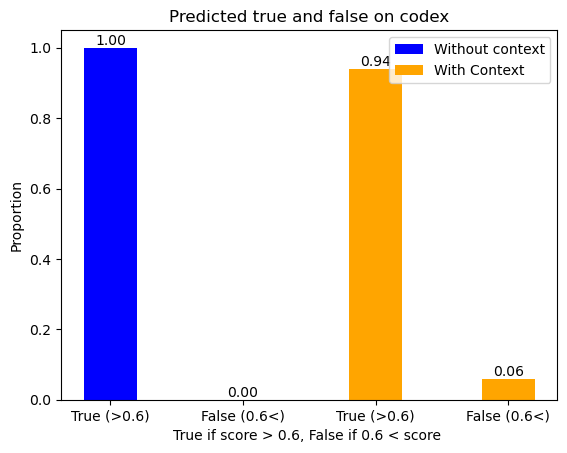

In [44]:
thresh = 0.6
# RESULT ON FB WITHOUT CONTEXT
base_bin = clean_score(base_list, thresh)
cont_bin = clean_score(cont_list, thresh)


# Example binary lists with different sizes
list1 = base_bin
list2 = cont_bin

# Calculate the proportion of 1s and 0s in each list
prop_true_base = sum(base_bin) / len(base_bin)
prop_false_base = 1 - prop_true_base
prop_true_cont = sum(list2) / len(list2)
prop_false_cont = 1 - prop_true_cont


# Define the labels and proportions
labels = [f'True (>{thresh})', f'False ({thresh}<)']
prop_base = [prop_true_base, prop_false_base]
prop_cont = [prop_true_cont, prop_false_cont]
#prop_cont_simp = [prop_true_cont_simp, prop_false_cont_simp]


# Define the positions of the bars
x1 = np.arange(len(labels))  # Positions for list1
x2 = x1 + len(labels)  # Positions for list2, with a gap
x3 = x2 + len(labels)

# Create the bar plot
fig, ax = plt.subplots()
bar1 = ax.bar(x1, prop_base, width=0.4, label='Without context', color='blue')
bar2 = ax.bar(x2, prop_cont, width=0.4, label='With Context', color='orange')
#bar3 = ax.bar(x3, prop_cont_simp, width=0.4, label='With triples cont.', color='red')

# Add labels, title, and legend
ax.set_xlabel(f'True if score > {thresh}, False if {thresh} < score ')
ax.set_ylabel('Proportion')
ax.set_title('Predicted true and false on codex')
ax.set_xticks(np.concatenate([x1, x2]))
ax.set_xticklabels(labels * 2)
ax.legend()

# Add values on top of the bars
ax.bar_label(bar1, fmt='%.2f')
ax.bar_label(bar2, fmt='%.2f')
#ax.bar_label(bar3, fmt='%.2f')

# Display the plot
plt.show()

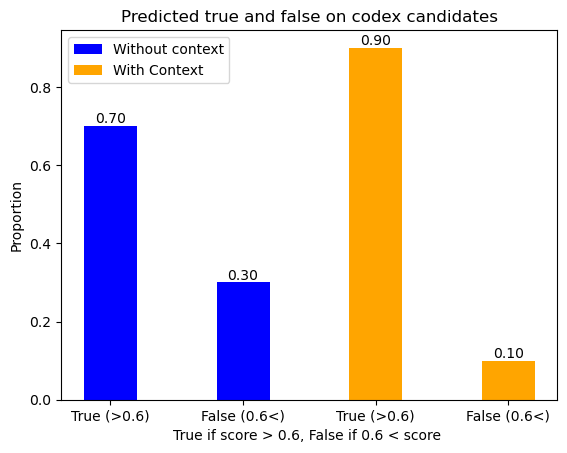

In [45]:
thresh = 0.6
# RESULT ON FB WITHOUT CONTEXT
base_bin = clean_score(base_cand_list, thresh)
cont_bin = clean_score(cont_cand_list, thresh)


# Example binary lists with different sizes
list1 = base_bin
list2 = cont_bin

# Calculate the proportion of 1s and 0s in each list
prop_true_base = sum(base_bin) / len(base_bin)
prop_false_base = 1 - prop_true_base
prop_true_cont = sum(list2) / len(list2)
prop_false_cont = 1 - prop_true_cont


# Define the labels and proportions
labels = [f'True (>{thresh})', f'False ({thresh}<)']
prop_base = [prop_true_base, prop_false_base]
prop_cont = [prop_true_cont, prop_false_cont]
#prop_cont_simp = [prop_true_cont_simp, prop_false_cont_simp]


# Define the positions of the bars
x1 = np.arange(len(labels))  # Positions for list1
x2 = x1 + len(labels)  # Positions for list2, with a gap
x3 = x2 + len(labels)

# Create the bar plot
fig, ax = plt.subplots()
bar1 = ax.bar(x1, prop_base, width=0.4, label='Without context', color='blue')
bar2 = ax.bar(x2, prop_cont, width=0.4, label='With Context', color='orange')
#bar3 = ax.bar(x3, prop_cont_simp, width=0.4, label='With triples cont.', color='red')

# Add labels, title, and legend
ax.set_xlabel(f'True if score > {thresh}, False if {thresh} < score ')
ax.set_ylabel('Proportion')
ax.set_title('Predicted true and false on codex candidates')
ax.set_xticks(np.concatenate([x1, x2]))
ax.set_xticklabels(labels * 2)
ax.legend()

# Add values on top of the bars
ax.bar_label(bar1, fmt='%.2f')
ax.bar_label(bar2, fmt='%.2f')
#ax.bar_label(bar3, fmt='%.2f')

# Display the plot
plt.show()